In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import operator

In [3]:
#load data
df_train = pd.read_csv("/content/drive/My Drive/airbnb-recruiting-new-user-bookings/train_users_2.csv")
df_test = pd.read_csv("/content/drive/My Drive/airbnb-recruiting-new-user-bookings/test_users.csv")

Gend=['MALE','FEMALE']

labels = df_train['country_destination'].values # Get the values of the country destination for each row
#df_train = df_train.drop(['country_destination'], axis=1) # It's the output variable for the decision tree
id_test = df_test['id']
piv_train = df_train.shape[0] # Size of df_train (number of rows)

df_train['account_created']=pd.to_datetime(df_train.date_account_created)
df_test['account_created']=pd.to_datetime(df_test.date_account_created)
av = df_train.age.values   #1914<age<2004-->date account created , age<10,110<age<151,age>2003-->mean age
av2=df_test.age.values
df_train['age'] = np.where(np.logical_and(av>1914, av<2004),df_train.account_created.dt.year-av, av)
df_test['age'] = np.where(np.logical_and(av2>1914, av2<2004),df_test.account_created.dt.year-av2, av2)

df_train['gender']=df_train['gender'].map(lambda x:random.choice(Gend) if x== '-unknown-' else x)
df_test['gender']=df_test['gender'].map(lambda x:random.choice(Gend) if x== '-unknown-' else x)

# Creating a dataframe that contains the training set and the testing set
# This will help us on transforming the data so that we apply the transormation for all the dataset instead of each
# We will separate both of them when applying the decision tree classification
df_all = pd.concat((df_train, df_test), axis = 0, ignore_index = True)

# We remove the id and the date of first booking since it is not used as an input to our classifier
df_all = df_all.drop(['id','date_first_booking'], axis=1)

# Missing values


# Date_account_created transformation
# Separate the day mounth and year into different columns
dac = np.vstack(df_all.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
print(dac)
df_all['dac_year'] = dac[:,0]
df_all['dac_mounth'] = dac[:,1]
df_all['dac_day'] = dac[:,2]
df_all = df_all.drop(['date_account_created'], axis = 1)
df_all = df_all.drop(['account_created'], axis = 1)


# timestamp_first_active transformation
# Here as well we separate the timestamp first active into day mount and year
tfa = np.vstack(df_all.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
print(tfa)
df_all['tfa_year'] = tfa[:,0]
df_all['tfa_month'] = tfa[:,1]
df_all['tfa_day'] = tfa[:,2]
df_all = df_all.drop(['timestamp_first_active'], axis=1)

# Age transformation
print(df_all.age.describe()) # We can see that the age has some inconsistancy variables
av = df_all.age.values
mean_age=int(df_all.age.mean())
df_all.age=df_all.age.fillna(value=mean_age)
df_all['age'] = np.where(av<10,mean_age, av)
df_all['age'] = np.where(av>2003,mean_age, av)
df_all['age'] = np.where(av>110,mean_age, av)


# Transforming the values into categorical values
features = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']

for f in features:
    df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
    df_all = df_all.drop([f], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[[2010    6   28]
 [2011    5   25]
 [2010    9   28]
 ...
 [2014    9   30]
 [2014    9   30]
 [2014    9   30]]
[[2009    3   19    4   32   55]
 [2009    5   23   17   48    9]
 [2009    6    9   23   12   47]
 ...
 [2014    9   30   23   54    8]
 [2014    9   30   23   54   30]
 [2014    9   30   23   59    1]]
count    158681.000000
mean         46.226511
std         136.303422
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64


In [0]:
X = df_all.iloc[:piv_train,:]
le = LabelEncoder()
y = le.fit_transform(labels)   
X_test = df_all.iloc[piv_train:,:]

In [5]:
X['new_age']=X.age

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
X.loc[X.age<18,'new_age']='Underage'
X.loc[(X.age>17) & (X.age<30),'new_age']='Twenty'
X.loc[(X.age>29) & (X.age<40),'new_age']='Thirty'
X.loc[(X.age>39) & (X.age<50),'new_age']='Fourty'
X.loc[(X.age>49) & (X.age<60),'new_age']='Fifty'
X.loc[(X.age>59) & (X.age<70),'new_age']='Sixty'
X.loc[(X.age>69),'new_age']='Over70'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
X['Age']=X['new_age']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
df=X[['Age','country_destination']]

In [0]:
x = df.groupby(['Age','country_destination']).size().to_frame('occurences').reset_index()

In [0]:
freq_df = df.groupby(['Age'])['country_destination'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)

Age에 따른 Destination

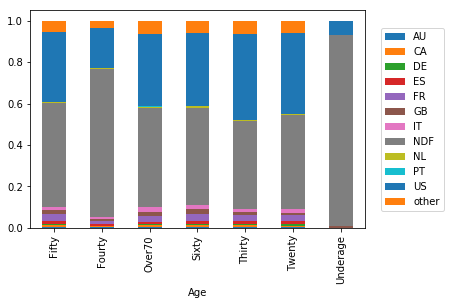

In [11]:
pct_df.plot(kind="bar", stacked=True)
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

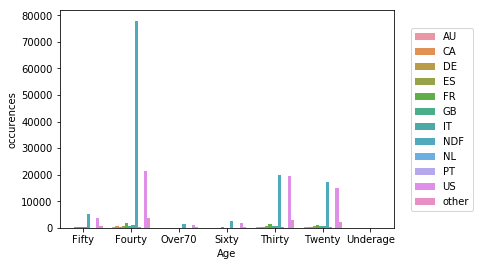

In [12]:
sns.barplot(x='Age', y='occurences', hue='country_destination', data=x)
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

FaceBook Singup 유무에 따른 Destination

In [0]:
df2=X[['signup_method_facebook','country_destination']]
x = df2.groupby(['signup_method_facebook','country_destination']).size().to_frame('occurences').reset_index()

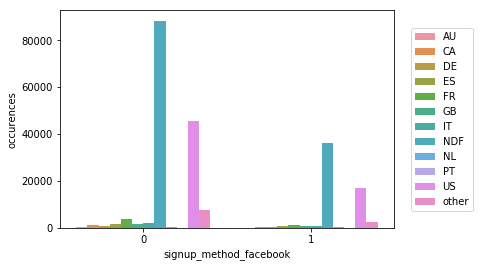

In [15]:
sns.barplot(x='signup_method_facebook', y='occurences', hue='country_destination', data=x)
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

In [0]:
freq_df = df2.groupby(['country_destination'])['signup_method_facebook'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)

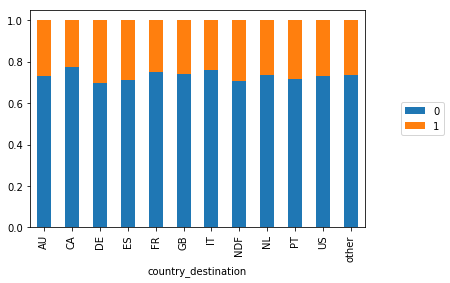

In [17]:
pct_df.plot(kind="bar", stacked=True)
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

Age에 따른 FaceBook Singup 유무

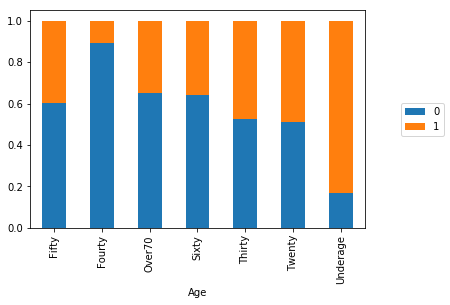

In [18]:
df3=X[['Age','signup_method_facebook']]
freq_df = df3.groupby(['Age'])['signup_method_facebook'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
pct_df.plot(kind="bar", stacked=True)
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

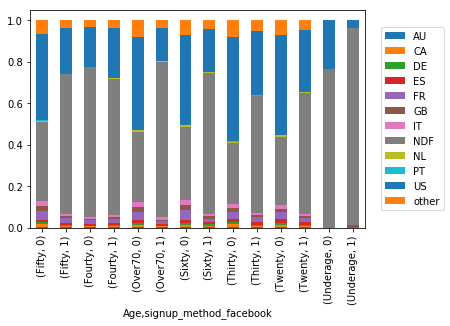

In [19]:
df4=X[['Age','signup_method_facebook','country_destination']]
freq_df = df4.groupby(['Age','signup_method_facebook'])['country_destination'].value_counts().unstack()
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)
pct_df.plot(kind="bar", stacked=True)
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

40대의 FaceBook SignUp 유뮤와 Destination의 관계

In [0]:
notf=df4.groupby(['Age','signup_method_facebook'])['country_destination'].get_group(('Fourty',0)).value_counts()
yesf=df4.groupby(['Age','signup_method_facebook'])['country_destination'].get_group(('Fourty',1)).value_counts()

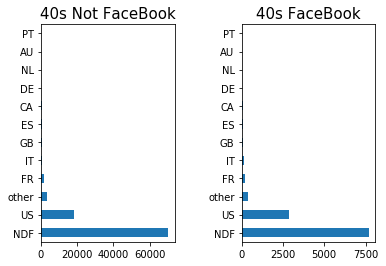

In [22]:
plt.subplot(121)
plt.subplots_adjust(wspace=0.5)
df4.groupby(['Age','signup_method_facebook'])['country_destination'].get_group(('Fourty',0)).value_counts().plot(kind = 'barh',stacked=True)
plt.title('40s Not FaceBook',fontsize=15)
plt.subplot(122)
df4.groupby(['Age','signup_method_facebook'])['country_destination'].get_group(('Fourty',1)).value_counts().plot(kind = 'barh',stacked=True)
plt.title('40s FaceBook',fontsize=15)
plt.show()

In [0]:
notf=pd.Series(notf)

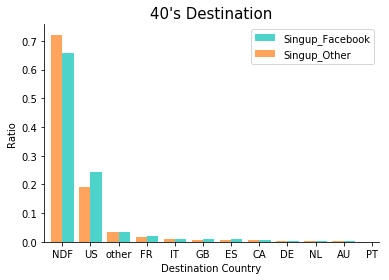

In [24]:
nf = sum(notf)
yf = sum(yesf)

female_destinations = notf/nf
male_destinations =yesf/yf

# Bar width
width = 0.4

male_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=0, label='Singup_Facebook', rot=0)
female_destinations.plot(kind='bar', width=width, color='#FFA35D', position=1, label='Singup_Other', rot=0)

plt.legend()
plt.title("40's Destination",fontsize=15)
plt.xlabel('Destination Country')
plt.ylabel('Ratio')

sns.despine()
plt.show()